Paths for Related Folders

In [1]:
path = "D:\Sem 6\EE6350 AI\Project\Dataset"

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Setting up data generaters

In [7]:
# Define image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation and test data
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = test_val_datagen.flow_from_directory(
    'validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    'test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


Building the model using EfficientNet

In [9]:
# Load pre-trained VGG16 without the top layer
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


58889256/58889256 [==============================] - 37s 1us/step


Train the model

In [10]:
# Set up callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('deepfake_model.h5', save_best_only=True)
]

# Train the model
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/30
3233/4375 [=====================>........] - ETA: 1:21:35 - loss: 0.5206 - accuracy: 0.7339

KeyboardInterrupt: 

Evaluate model

In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

341/341 [==============================] - 1673s 5s/step - loss: 0.5430 - accuracy: 0.7148
Test accuracy: 0.7148


make predictions of new image

1/1 [==============================] - 0s 35ms/step
Prediction: Real (Confidence: 0.76)


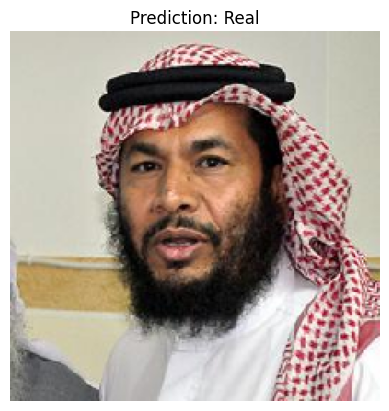

In [18]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    prediction = model.predict(img_array)
    result = "Real" if prediction[0][0] > 0.5 else "Fake"
    confidence = prediction[0][0] if result == "Real" else 1 - prediction[0][0]
    
    print(f"Prediction: {result} (Confidence: {confidence:.2f})")
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()
    
# Test with a sample image
predict_image('./validation/Real/real_0.jpg')